In [663]:
import tensorflow as tf
# tf.debugging.set_log_device_placement(True)  # to  visualize which functions are assigned to which device(CPU or GPU)
# # by default, GPU is assigned priority for tensorflow. To disable it, run this:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [664]:
from IPython.core import display
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from math import pi
import tf_kdl as tk
from tf_quaternion import *
from scipy.spatial.transform import Rotation as R
import tensorflow_probability as tfp
from utils import *
plt.style.use("default")
%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup of some functions and variables


In [665]:
def rotvec2mat(x):
    return R.as_matrix(R.from_rotvec(x))

In [666]:
# Loading the rivet positions in 3D position vectors
targets_x = np.load("targets_x.npy", allow_pickle=True)
targets_orn = np.load("targets_orn.npy", allow_pickle=True)
rotation_axes = np.load('rotation_axes.npy', allow_pickle=True)

In [780]:
# Using tensorflow implementation of KDL, get the urdf, chain and dyn parameters
urdf = tk.utils.urdf_utils.urdf_from_file('urdf/panda/panda_arm_kdl.urdf')
chain = tk.utils.urdf_utils.tk_chain_from_urdf(urdf)
dyn = tk.ChainDynParam(chain)


chain None


Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link0']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link1']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link2']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link4']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link5']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link6']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link7']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_hand']/collision[1]


In [668]:
# Transformations from world frame(bullet) of the simulation to the robot frame(kdl):
# For Panda on the floor and for this paper, we used the same frame, but the user can change it from here.
base_pos = tf.cast(np.array([0., 0., 0.])[None], tf.float32)
base_rot_vec = np.array([0., 0., 0.])
base_rot_mat = tf.cast(rotvec2mat(base_rot_vec), tf.float32)
base_rot_mat_inv = tf.cast(tf.transpose(base_rot_mat), tf.float32)

def kdl2bullet_x(x):
    """
    param: x: [batch, 3] position in kdl (wrt robot base frame)
    return: [batch, 3] position in bullet (wrt bullet world frame)
    """
    return tf.einsum('ij, aj->ai',base_rot_mat, x) + base_pos

def bullet2kdl_x(x):
    """
    param: x: [batch, 3] position in bullet (wrt bullet world frame)
    return: [batch, 3] position in kdl (wrt robot base frame)
    """
    return tf.einsum('ij, aj->ai',base_rot_mat_inv, x - base_pos)

def kdl2bullet_q(x):
    """
    param: x: [batch, 9] vectorized rotation matrix in kdl (wrt robot base frame)
    return: [batch, 4] quaternion vector in bullet (wrt bullet world frame)
    """
    kdl_end_rot_mat = tf.reshape(x, (x.shape[0], 3,3))
    world_end_rot_mat =  tf.einsum('ij, ajk->aik', base_rot_mat, kdl_end_rot_mat)
    return rot2quat(world_end_rot_mat)

def bullet2kdl_q(x):
    """
    param: x: [batch, 9] vectorized rotation matrix in bullet (wrt bullet world frame)
    return: [batch, 4] quaternion vector in kdl (wrt robot base frame)
    """
    world_end_rot_mat = tf.reshape(x, (x.shape[0], 3,3))
    kdl_end_rot_mat =  tf.einsum('ij, ajk->aik', base_rot_mat_inv, world_end_rot_mat)
    return rot2quat(kdl_end_rot_mat)
        
def kdl2bullet_xq(x):
    """
    param: x: [batch, 12] position + vectorized rotation matrix in kdl (wrt robot base frame)
    return: [batch, 3], [batch, 4]  position, quaternion in bullet (wrt bullet world frame)
    """
    return kdl2bullet_x(x[:, :3]), kdl2bullet_q(x[:, 3:])

def bullet2kdl_xq(x):
    """
    param: x: [batch, 12] position + vectorized rotation matrix in bullet (wrt bullet world frame)
    return: [batch, 3], [batch, 4]  position, quaternion in kdl (wrt robot base frame)
    """
    return bullet2kdl_x(x[:, :3]), bullet2kdl_q(x[:, 3:])


### Defining the end-pose cost

In [669]:
def quat2format_scalar_first(x):
    return np.array([x[-1], x[0], x[1], x[2]])

def prec_from_mu(mu, R):
    quats_xyz = Quaternion(create_unit_rotations(angle=pi/2, R=R))
    mu_  = Quaternion(tf.tile(mu, (3,1)))
    rot_mu =  mu_ * quats_xyz
    u = Quaternion(rot_mu) - mu_
    u = u/tf.linalg.norm(u, axis=-1)[:,None]
    norms = tf.constant([1, 1e-4, 1e-4]) # this defines the precision
    cov = tf.reduce_sum(tf.einsum('k,kij->kij', 
                                      norms,
                                      tf.einsum('ki, kj->kij',u,u)), axis=0)
    cov += 1e-6 * tf.eye(4)

    prec = tf.linalg.inv(cov)
    return prec

In [670]:
# Quaternion cost
def normalS3_log_prob_(mu_quat, prec, batch):
    """
    mu_quat: [hole_nb, 1, 4]
    prec: [hole_nb, 4, 4]
    """
    mu = Quaternion(tf.tile(mu_quat, (1, batch, 1)))
    def normalS3_log_prob(x):
        """
        x : [hole_nb, batch_nb, 4]
        Quaternion lognormal distribution
        """
        diff = x - mu
        quad = -0.5*tf.linalg.einsum('hbi,hbi->hb',diff, tf.linalg.einsum('hij,hbj->hbi',prec,diff))
        return quad
    return normalS3_log_prob

In [671]:
# Position cost
cov_x = tf.linalg.diag([1e-3, 1e-3, 1e-3])
prec_x = tf.linalg.inv(cov_x)

def normal_log_prob_(mu_x):
    """
    mu_x : [hole_nb, 1, 3]
    """
    def normal_log_prob(x):
        """
        x: [hole_nb, batch_nb, 3]
        Cartesian lognormal distribution
        """
        diff = x - mu_x
        quad = -0.5*tf.linalg.einsum('hbi,hbi->hb',diff, tf.linalg.einsum('ij,hbj->hbi',prec_x,diff))
        return quad
    return normal_log_prob

### Joint limit costs

In [672]:
joint_limits = tf.stack(chain.joint_limits)
lower_limits = joint_limits[:,0][None, None]
upper_limits = joint_limits[:,1][None, None]
def plot_limits(q):
    plt.plot(joint_limits, "o")
    plt.plot(q, "kx")
    
mean_limits = tf.reduce_mean(joint_limits,-1)[None]
@tf.function
def cost_joint_limit(q):
    rl = tf.math.minimum(q-lower_limits, 0)
    ru = tf.math.maximum(q-upper_limits, 0)
    return 0.5*(tf.linalg.einsum('hbi,hbi->hb',rl, rl) + tf.linalg.einsum('hbi,hbi->hb',ru, ru))


### Optimization to find the joint configuration corresponding to rivet hole positions within joint limits

In [673]:
labels = ["up", "mid", "down"]

In [674]:
hole_nb = 0
for label in labels:
    hole_nb += targets_x.item()[label].shape[0]
print(hole_nb)

64


In [675]:
mu_pos = tf.cast(tf.concat([targets_x.item()[name][:,None] for name in labels],0), tf.float32)

In [676]:
mu_orn = tf.cast(
    tf.concat([
    tf.tile(quat2format_scalar_first(targets_orn.item()[name])[None,None],(targets_x.item()[name].shape[0],1,1)) for name in labels],0),
    tf.float32)

In [677]:
precs_orn = tf.concat([
    tf.tile(
        prec_from_mu(
            tf.cast(
                quat2format_scalar_first(targets_orn.item()[name])[None],
                tf.float32),
            tf.cast(
                rotation_axes.item()[name], tf.float32
            )
        )[None],
        (targets_x.item()[name].shape[0],1,1))
    for name in labels], 0)

In [678]:
# Start is the initial guess on the joint configurations within the joint limits
batch = 3000
initial_val =tf.random.uniform(shape=(hole_nb, batch, 7),
                      minval=tf.stack(chain.joint_limits)[:,0],
                      maxval=tf.stack(chain.joint_limits)[:,1])

q_left = tf.tile(np.array([-0.93647355, -0.85181572,  1.39629791, -2.03780449,  1.14492687,
        3.27162269,  2.7709552 ])[None, None], (hole_nb, batch//2, 1))

q_right = tf.tile(np.array([ 0.88689171, -1.25769221, -0.70598013, -1.90600929,  2.92777794,
        3.81677752, -1.94067666])[None, None], (hole_nb, batch//2, 1))

reg_val = tf.cast(tf.concat([q_left, q_right],axis=1), tf.float32)
reg_val = reg_val[:,:1]
start  = tf.Variable(initial_val)


# # Initialize from pretrained configurations
# good_q = np.load("good_q.npy",allow_pickle=True)
# batch = good_q.shape[1]
# start = tf.Variable(good_q[:,:batch])

In [679]:
pos_log_prob = normal_log_prob_(mu_pos)
orn_log_prob = normalS3_log_prob_(mu_orn, precs_orn, batch)

In [680]:
# with jacobian, i would need to take inverse of the jacobian which is very expensive when considered batch formulation
@tf.function
def cost_ik(q):
    """
    q: [hole_nb, batch_nb, nb_dof]
    """
    batch = q.shape[1]
    q_vec = tf.reshape(q, (hole_nb*batch, q.shape[2]))
    xs_ = chain.xs(q_vec, layout=tk.FkLayout.xm)[:, -1]
    
    # if robot base frame is changed, uncomment this
    # world_end_pos, world_end_quats = kdl2bullet_xq(xs_)
    
    world_end_pos = tf.reshape(xs_[..., :3], (hole_nb, batch, 3))
    world_end_quats = rot2quat(tf.reshape(xs_[...,3:], (hole_nb*batch, 3, 3)))
    world_end_quats = tf.reshape(world_end_quats, (hole_nb, batch, 4))
        
    ee_pos_cost = -pos_log_prob(world_end_pos)
    ee_quat_cost = -orn_log_prob(Quaternion(world_end_quats))
    return ee_pos_cost, ee_quat_cost


In [681]:
def regularize(q):
    diff = q-reg_val
    return tf.reduce_sum(diff**2, -1)

def get_pos_orn(q):
    batch = q.shape[1]
    q_vec = tf.reshape(q, (hole_nb*batch, q.shape[2]))
    xs_ = chain.xs(q_vec, layout=tk.FkLayout.xm)[:, -1]
    
    world_end_pos = tf.reshape(xs_[..., :3], (hole_nb, batch , 3))
    world_end_quats = rot2quat(tf.reshape(xs_[...,3:], (hole_nb*batch, 3, 3)))
    world_end_quats = tf.reshape(world_end_quats, (hole_nb, batch, 4))
    
    return world_end_pos, world_end_quats

In [682]:
optimizer = tf.keras.optimizers.Adam(0.1)

In [683]:
@tf.function
def train_step(lmb_pos, lmb_quat):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(start)
        start_ = tf.nn.sigmoid(start)*(upper_limits-lower_limits)+lower_limits
        loss_pos, loss_orn = cost_ik(start_)
        loss = lmb_pos*loss_pos + lmb_quat*loss_orn + regularize(start_)*1e-4
        
    grads = tape.gradient(loss, [start])
    grads_ = grads[0]
    # removing nans
    grads_ = tf.where(tf.math.is_nan(grads_), tf.zeros_like(grads_), grads_)
    optimizer.apply_gradients(zip([grads_], [start]))
    return loss_pos, loss_orn, grads

In [684]:
lmb_pos = tf.constant(1e0)
lmb_quat = tf.constant(1e-1)

In [685]:
for i in range(1000):
    try :
        loss_pos, loss_orn, _ = train_step(lmb_pos, lmb_quat)
        display.clear_output(wait=True)
        print(loss_pos[:5,:5].numpy(),'\n','\n', loss_orn[:5,:5].numpy())
    except KeyboardInterrupt:
        break

[[1.822e-05 5.485e+00 3.262e-04 1.599e-05 6.047e+00]
 [3.975e+00 8.207e-03 7.974e-06 8.394e-01 3.304e+00]
 [8.444e-06 4.320e+00 3.716e+00 1.306e-04 1.160e+02]
 [3.099e+01 7.115e-06 4.619e+00 4.872e+00 2.727e-01]
 [4.983e+00 9.570e-02 4.655e+00 3.324e+01 2.322e-03]] 
 
 [[1.573e-01 5.018e+01 5.037e-02 1.569e-02 8.928e+01]
 [4.168e+01 5.165e-01 4.627e-01 8.644e-02 8.775e+00]
 [2.214e-02 7.279e+01 4.575e+01 4.040e-01 1.966e+02]
 [2.554e+02 3.878e-02 1.522e+01 1.045e+01 4.144e+00]
 [2.541e+01 1.594e+00 3.465e+01 2.165e+02 1.620e-01]]


### Filtering to get converging solutions

In [686]:
# first version of the found joint configurations,
# some may not be within the joint limits nor correspond to rivet positions since the SGD did not converge
good_q___ = tf.nn.sigmoid(start)*(upper_limits-lower_limits)+lower_limits
good_q___.shape

TensorShape([64, 3000, 7])

In [687]:
# Second version containing all the solutions in the joint configurations
good_q__ = [None for i in range(hole_nb)]
max_nb = 1e5
for i in range(hole_nb):
    good_q__[i] = good_q___[i][cost_joint_limit(good_q___)[i] < 1e-1]
    max_nb = min(max_nb,good_q__[i].shape[0])
    
for i in range(hole_nb):
    good_q__[i] = good_q__[i][:max_nb]
    
good_q__ = tf.stack(good_q__)
good_q__.shape

TensorShape([64, 3000, 7])

In [688]:
xs, orn_xs = get_pos_orn(good_q__)

In [689]:
# third version of the joint configurations, within joint limits and within the tolerance of corresponding rivet position
good_q_ = [None for i in range(hole_nb)]
max_nb = 1e5
for i in range(hole_nb):
    good_q_[i] = good_q__[i][-pos_log_prob(xs)[i] < 1e-1]
#     print(good_q[i].shape[0])
    max_nb = min(max_nb,good_q_[i].shape[0])
    
for i in range(hole_nb):
    good_q_[i] = good_q_[i][:max_nb]
    
good_q_ = tf.stack(good_q_)
good_q_.shape

TensorShape([64, 723, 7])

In [690]:
xs, orn_xs = get_pos_orn(good_q_)

In [691]:
orn_log_prob = normalS3_log_prob_(mu_orn, precs_orn, good_q_.shape[1])

In [692]:
# fourth version of the joint configurations, within joint limits and within the tolerance of corresponding rivet position
good_q = [None for i in range(hole_nb)]
max_nb = 1e5
for i in range(hole_nb):
    good_q[i] = good_q_[i][-orn_log_prob(Quaternion(orn_xs))[i] < 1e1]
    max_nb = min(max_nb,good_q[i].shape[0])
    
for i in range(hole_nb):
    good_q[i] = good_q[i][:max_nb]
    
good_q = tf.stack(good_q)
good_q.shape

TensorShape([64, 713, 7])

In [693]:
# check if there is any nan
if tf.where(tf.math.is_nan(good_q) == True).shape[0] == 0:
    print("no nan")
else:
    print("check nans")

no nan


In [694]:
np.save('good_q', good_q, allow_pickle=True)

### Fourier series of the force

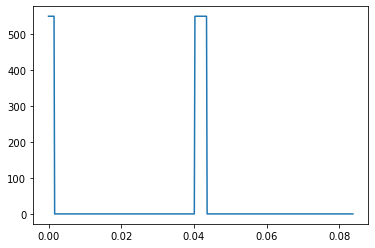

In [695]:
def rect(T):
    """create a centered rectangular pulse of width $T"""
    return lambda t: (-T/2 <= t) & (t < T/2)

def pulse_train(t, at, shape):
    """create a train of pulses over $t at times $at and shape $shape"""
    return np.sum(shape(t - at[:,np.newaxis]), axis=0)
w = 150.
f = w/(2*np.pi)# frequence
T = 1./f # period
Tf = T*2 # time
N = 500 # timesteps
N_period = T*N/Tf

Td = T*0.08
Fm = 550
t = np.linspace(0, Tf, N)
sig = pulse_train(
    t=t,              # time domain
    at=np.arange(0, Tf, T),  # times of pulses
    shape=rect(Td)                 # shape of pulse
)

plt.plot(t, Fm*sig)

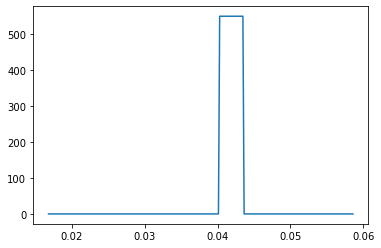

In [696]:
_t0 = 100
_tf = int(_t0 + N_period)
plt.plot(t[_t0:_tf],  Fm*sig[_t0:_tf])
t_ = t[_t0:_tf]
x = Fm*sig[_t0:_tf]

In [697]:
K = 10
Fks = []
Fk_all = []
for k in range(K):
    Fk = np.mean(x * np.exp(-2*1j*np.pi*t_*k/T))
    Fk_all += [Fk]
    Fks.append(np.real(Fk))


In [698]:
x_hat = 0
for k in range(0,K):
    x_hat += 2 * Fks[k] * np.cos(2*np.pi*t_*k/T)

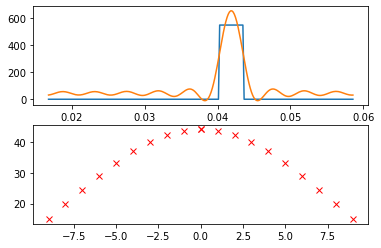

In [699]:
fig,ax = plt.subplots(2)
ax[0].plot(t_, x)
ax[0].plot(t_, x_hat)
ax[1].plot(range(K), Fks, "rx")
ax[1].plot(range(-K+1,1), np.flip(Fks), "rx")

### Displacement cost

In [700]:
# Force: 
F_bar = tf.cast(tf.stack(Fks), tf.float32)

# Force directions
axis_force = np.zeros((hole_nb, 3))
ax = np.array([0., 0., 1])
hole_nb1 = targets_x.item()[labels[0]].shape[0]
hole_nb2 = targets_x.item()[labels[0]].shape[0] + targets_x.item()[labels[1]].shape[0]

R = w2mat(quat2w(euler2quat([0,np.pi/2,0.])))
axis_force[hole_nb1:hole_nb2] = R@ax
v2=R@ax
ax = -v2

R = w2mat(quat2w(euler2quat([0,10,0.])))
axis_force[:hole_nb1] = R@ax
v1=R@ax

R = w2mat(quat2w(euler2quat([0,-10,0.])))
axis_force[hole_nb2:] = R@ax
v3=R@ax
axis_force = tf.cast(axis_force, tf.float32)

F_vec = tf.einsum('k, ai->kai',F_bar[1:], axis_force)

print(hole_nb1, hole_nb2, hole_nb)

16 48 64


In [701]:
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook
# p0 = v1
# p1 = v2
# p2 = v3

# origin = [0,0,0]
# X, Y, Z = zip(origin,origin,origin) 
# U, V, W = zip(p0,p1,p2)
# colors=["b", "r", "g"]
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for i in range(3):
#     ax.quiver(X[i],Y[i],Z[i],U[i],V[i],W[i],arrow_length_ratio=0.01, colors=colors[i], label=labels[i])
# ax.set_xlabel('X axis')
# ax.set_ylabel('Y axis')
# ax.set_zlabel('Z axis')
# ax.legend()
# plt.show()

In [781]:
# For 7dof robot
K_ = tf.eye(chain.nb_joint)*1e5
C_ = tf.linalg.diag(tf.ones(7)*0.06)
C_inv = tf.linalg.diag(1./(tf.ones(7)*0.06))

# chosen frequency in rad/s
ws = tf.stack([k*w for k in range(1,K)])
ws_sq_neg = -(ws**2)

B = tf.einsum('i,bc->ibc',ws,C_)[:, None,None]
B_inv = tf.einsum('i,bc->ibc',1./ws,C_inv)[:, None,None]


In [782]:
@tf.function
def displacement(q):
        b1 = q.shape[0]
        b2 = q.shape[1]
        q_vec = tf.reshape(q, (b1*b2, 7))
        M = tf.reshape(dyn.inertia_matrix(q_vec), (b1,b2,7,7))
        J = tf.reshape(chain.jacobian(q_vec, layout=tk.FkLayout.x), (b1,b2,3,7))
        A = tf.einsum('k,hbij->khbij',ws_sq_neg,M)+K
        term1 = A@B_inv@A+B
        term1_inv = tf.linalg.inv(term1)
        X = B_inv@A@term1_inv
        H = tf.einsum('khbim, hbjm->khbij',tf.einsum('hbij,khbmj->khbim',J,X), J)
        return tf.reduce_sum(tf.einsum('khbij,khj->khbi',H, 2*F_vec), 0)


### Optimization for displacement

In [866]:
def squash(raw_q):
    return tf.nn.sigmoid(raw_q)*(upper_limits-lower_limits)+lower_limits

def inv_squash(good_q):
    raw_q = (good_q - lower_limits)/(upper_limits-lower_limits)
    raw_q = tf.math.log(raw_q/(1-raw_q)+1e-20)
    return raw_q



In [867]:
good_q = np.load("good_q.npy", allow_pickle=True)
good_q_inv = inv_squash(good_q)

In [868]:
# select batch to be equal or smaller to good_q.shape[1]
good_q_inv.shape[1]

713

In [869]:
batch = good_q_inv.shape[1]

In [870]:
q_test = tf.Variable(good_q_inv[:, :batch], trainable=True)
# q_test = tf.Variable(initial_val[:, :batch], trainable=True)

In [871]:
orn_log_prob = normalS3_log_prob_(mu_orn, precs_orn, batch)
@tf.function
def cost_ik(q):
    """
    q: [hole_nb, batch_nb, nb_dof]
    """
    batch = q.shape[1]
    q_vec = tf.reshape(q, (hole_nb*batch, q.shape[2]))
    xs_ = chain.xs(q_vec, layout=tk.FkLayout.xm)[:, -1]

    world_end_pos = tf.reshape(xs_[..., :3], (hole_nb, batch, 3))
    world_end_quats = rot2quat(tf.reshape(xs_[...,3:], (hole_nb*batch, 3, 3)))
    world_end_quats = tf.reshape(world_end_quats, (hole_nb, batch, 4))
        
    ee_pos_cost = -pos_log_prob(world_end_pos)
    ee_quat_cost = -orn_log_prob(Quaternion(world_end_quats))
    return ee_pos_cost, ee_quat_cost

In [872]:
optimizer = tf.keras.optimizers.Adam(0.01)

In [873]:
@tf.function
def train_step(lmb_pos, lmb_orn, lmb_disp):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(q_test)
        q_ = squash(q_test)
        loss_pos, loss_orn = cost_ik(q_)
        d =  displacement(q_)
        loss_disp = tf.linalg.norm(d, axis=-1)
#         loss_disp = tf.norm(loss_disp, ord=1)[None, None]
        loss = lmb_pos*loss_pos + lmb_quat*loss_orn + lmb_disp*loss_disp
        
    grads = tape.gradient(loss, [q_test])
    grads_ = grads[0]
    # removing nans
#     tf.print(tf.where(tf.math.is_nan(grads_)))
    grads_ = tf.where(tf.math.is_nan(grads_), tf.zeros_like(grads_), grads_)
    
    optimizer.apply_gradients(zip([grads_], [q_test]))
    return loss_pos, loss_orn, loss_disp, grads_
#     return loss_disp, grads

In [925]:
# lmb_disp = tf.constant(1e4+1000)
lmb_disp = tf.constant(1e3+100)
lmb =1e1

In [926]:
for i in range(1000):
    try :
        loss_pos, loss_orn, loss_disp,  grads = train_step(lmb_pos*lmb, lmb_quat*lmb*1e9, lmb_disp)
        display.clear_output(wait=True)
#         print(loss_pos.numpy(), '\n',loss_orn.numpy(), '\n', loss_disp.numpy(), '\n' )
        print(i, loss_orn.numpy()[:5,:5],'\n',loss_disp.numpy()[:5,:5] )
#         print((loss_disp*lmb_disp).numpy()[:, 0,0])
#         print(loss_pos.numpy()[:5, :5])
#         print(tf.where(tf.math.is_nan(q_test)))
    except KeyboardInterrupt:
        break

663 [[1.14  2.186 2.17  1.11  1.175]
 [1.868 1.275 1.481 1.258 1.39 ]
 [1.294 0.552 1.279 0.176 1.286]
 [1.416 0.515 0.889 0.954 1.382]
 [3.601 0.096 1.083 0.651 3.572]] 
 [[0.006 0.004 0.004 0.004 0.004]
 [0.004 0.006 0.004 0.004 0.006]
 [0.004 0.007 0.004 0.007 0.004]
 [0.004 0.003 0.003 0.006 0.005]
 [0.004 0.003 0.005 0.007 0.004]]


In [927]:
q_after_disp = squash(q_test)
good_q_cut = good_q[:, :batch]
xs, orn_xs = get_pos_orn(q_after_disp)

In [928]:
q_after_disp.shape

TensorShape([64, 713, 7])

In [929]:
good_q_ = [None for i in range(hole_nb)]
good_q_selected_ = [None for i in range(hole_nb)]
max_nb = 1e5
for i in range(hole_nb):
    good_q_[i] = q_after_disp[i][-pos_log_prob(xs)[i] < 1e-1]
    good_q_selected_[i] = good_q_cut[i][-pos_log_prob(xs)[i] < 1e-1]
#     print(good_q[i].shape[0])
    max_nb = min(max_nb,good_q_[i].shape[0])
    
for i in range(hole_nb):
    good_q_[i] = good_q_[i][:max_nb]
    good_q_selected_[i] = good_q_selected_[i][:max_nb]
    
good_q_ = tf.stack(good_q_)
good_q_selected_ = tf.stack(good_q_selected_)
batch__ = good_q_.shape[1]
batch__

712

In [930]:
xs, orn_xs = get_pos_orn(good_q_)
orn_log_prob = normalS3_log_prob_(mu_orn, precs_orn, batch__)

In [931]:
opt_q = [None for i in range(hole_nb)]
good_q_selected = [None for i in range(hole_nb)]
max_nb = 1e5
for i in range(hole_nb):
    opt_q[i] = good_q_[i][-orn_log_prob(Quaternion(orn_xs))[i] < 1e1]
    good_q_selected[i] = good_q_selected_[i][-orn_log_prob(Quaternion(orn_xs))[i] < 1e1]
#     print(opt_q[i].shape[0])
    max_nb = min(max_nb,opt_q[i].shape[0])
    
for i in range(hole_nb):
    opt_q[i] = opt_q[i][:max_nb]
    good_q_selected[i] = good_q_selected[i][:max_nb]
    
opt_q = tf.stack(opt_q)
good_q_selected = tf.stack(good_q_selected)
batch_ = opt_q.shape[1]
batch_

705

In [932]:
after_opt_data = displacement(opt_q)*1e3 
before_opt_data = displacement(good_q_selected)*1e3
# before_opt_data = displacement(good_q)*1e3

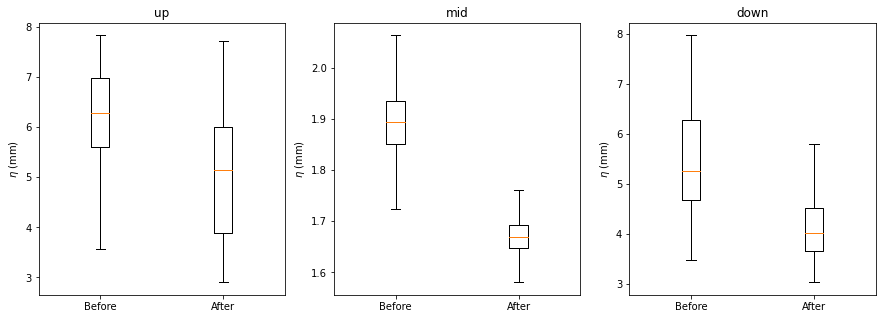

In [933]:
%matplotlib inline
fig,axes = plt.subplots(ncols=3 , figsize=(15,5))
density = 1

distance_before = tf.linalg.norm(before_opt_data,axis=-1).numpy()
distance_after = tf.linalg.norm(after_opt_data,axis=-1).numpy()

indices = [range(hole_nb1), range(hole_nb1,hole_nb2), range(hole_nb2,hole_nb)]

for k,ax in enumerate(axes):
    
    ax.boxplot([distance_before[indices[k]].flatten(), distance_after[indices[k]].flatten()], showfliers=False)

    ticks = ["Before", "After"]
    ax.set_xticks([1,2])
    ax.set_xticklabels( ticks, rotation=0 )
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_ylabel('$\eta$'+' (mm)')

    ax.set_title(labels[k])
    k +=1

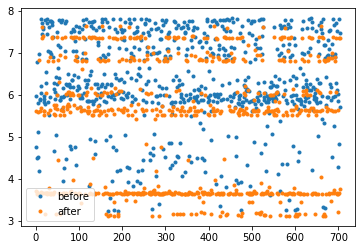

In [934]:
hole = 0
plt.plot(tf.linalg.norm(before_opt_data[hole], axis=-1), ".", label="before")
plt.plot(tf.linalg.norm(after_opt_data[hole], axis=-1), ".", label="after")
plt.legend()

In [935]:
# %matplotlib inline
# titles = ["All coordinates", "Distance"]
# fig,axes = plt.subplots(ncols=2 , figsize=(10,5))
# density = 1
# k = 0

# for ax in axes:
    
#     if k == 0:
#         ax.boxplot([ before_opt_data.numpy().flatten(), after_opt_data.numpy().flatten()], showfliers=False)
#     else:
#         ax.boxplot([tf.linalg.norm(before_opt_data,axis=-1).numpy().flatten(), 
#                     tf.linalg.norm(after_opt_data,axis=-1).numpy().flatten()], showfliers=False)

#     ticks = ["Before", "After"]
#     ax.set_xticks([1,2])
#     ax.set_xticklabels( ticks, rotation=0 )
#     ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#     ax.set_ylabel('$\eta$'+' (mm)')

#     ax.set_title(titles[k])
#     k +=1

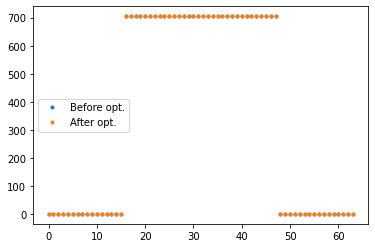

In [936]:
threshold = 2.2
fig,ax = plt.subplots()
ax.plot(np.sum(tf.linalg.norm(before_opt_data,axis=-1).numpy()<threshold, -1), ".",label="Before opt.")
ax.plot(np.sum(tf.linalg.norm(after_opt_data,axis=-1).numpy()<threshold, -1), ".", label="After opt.")
ax.legend(loc='center left')

In [937]:
dict_planning = {'qs':opt_q.numpy(), 'disp':after_opt_data.numpy()}

In [938]:
np.save('riveting_results', dict_planning , allow_pickle=True)

In [ ]:
# j = 0

In [ ]:
# # run this cell many times to visualize the results for different rivet holes
# plt.plot(tf.linalg.norm(displacement(good_q[j,:batch][None])[0],axis=-1), "bx", label="Before optimization")
# plt.plot(tf.linalg.norm(displacement(squash(q_test)[j][None])[0],axis=-1), "rx", label="After optimization")
# plt.legend()
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# j+=1

In [ ]:
# fig,axes=plt.subplots(ncols=2,figsize=(10,5))
# density = 1
# after_opt_data = displacement(squash(q_test))
# before_opt_data = displacement(good_q[:,:batch])
# k = 0
# for ax in axes:
#     if k == 0:
        
        
#         ax.hist(after_opt_data.numpy()[...,0].flatten(),density=density,color="b", label="After optimization")
#         ax.hist(before_opt_data.numpy()[...,0].flatten(), color="r",density=density, alpha=0.3, label="Before optimization")
#         ax.plot(after_opt_data.numpy()[...,0].flatten(), np.ones_like(after_opt_data.numpy()[...,0].flatten())*(-100), "bx", alpha=0.1)
#         ax.plot(before_opt_data.numpy()[...,0].flatten(), np.ones_like(after_opt_data.numpy()[...,0].flatten())*(-300), "rx", alpha=0.1)
      
#     else:
#         ax.hist(tf.linalg.norm(after_opt_data,axis=-1).numpy().flatten(), density=density, color="b", label="After optimization")
#         ax.hist(tf.linalg.norm(before_opt_data,axis=-1).numpy().flatten(), density=density, alpha=0.3, color="r", label="Before optimization")
#         ax.plot(after_opt_data.numpy().flatten(), np.ones_like(after_opt_data.numpy().flatten())*(-0.1), "bx", alpha=0.1)
#         ax.plot(before_opt_data.numpy().flatten(), np.ones_like(after_opt_data.numpy().flatten())*(-0.2), "rx", alpha=0.1)
#     ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#     ax.set_xlabel('$\eta$'+' (mm/N)')
#     ax.set_ylabel("density")
#     secax = ax.secondary_xaxis('top', functions=(forward, inverse))
#     secax.set_xlabel('$\Delta x$'+' (mm)')
#     secax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#     ax.legend(loc=7)

#     ax.set_yticks([])
#     ax.set_title(titles[k])
#     k += 1